In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip ./sign-language-mnist.zip

100% 62.6M/62.6M [00:00<00:00, 145MB/s]

Archive:  ./sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2 as cv
import urllib
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(42)

In [4]:
train_path = './sign_mnist_train/sign_mnist_train.csv'
test_path = './sign_mnist_test/sign_mnist_test.csv'

In [5]:
train = pd.read_csv(train_path) # import training data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [6]:
test = pd.read_csv(test_path) # import test set
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [7]:
print('shape of training data:', train.shape) # (nrow, ncolumn)
print('shape of testing data:', test.shape) # (nrow, ncolumn)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count train:', train.isna().sum().sum())
print('na count test:', test.isna().sum().sum())

shape of training data: (27455, 785)
shape of testing data: (7172, 785)
na count train: 0
na count test: 0


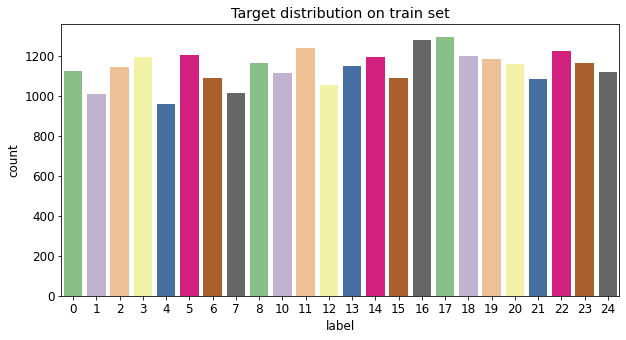

In [9]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x=train['label'], palette='Accent') # plot train label distribution
plt.title('Target distribution on train set')
plt.show()

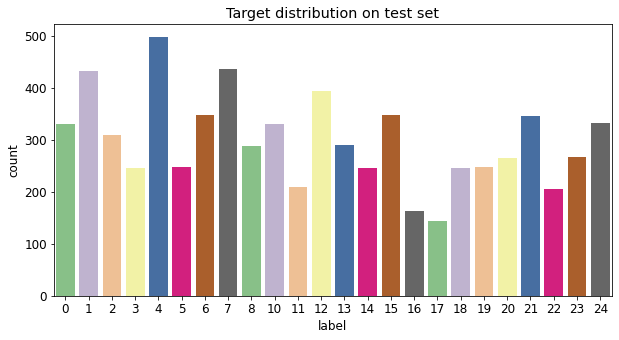

In [10]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x=test['label'], palette='Accent') # plot test label distribution
plt.title('Target distribution on test set')
plt.show()

we could notice that there are no example in both train set and test set with label 9

In [11]:
X = train.drop('label', axis=1) # features
y = keras.utils.to_categorical(train['label']) # encode target

X_test = test.drop('label', axis=1)
y_test = keras.utils.to_categorical(test['label'])

In [12]:
# reshape square black and white images
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(X.shape[1] ** (1/2)) , 1
    return X.values.reshape(samples, width, width, channel)  

In [13]:
X = reshape_bw(X)
X_test = reshape_bw(X_test)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

label: 3


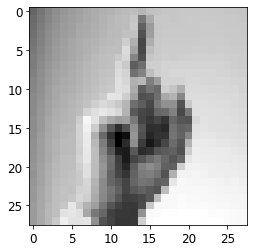

label: 6


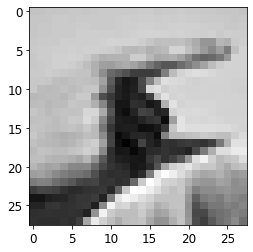

In [14]:
# plot a square black and white image
def plot_image(X, width):
    _ = plt.imshow(X.reshape(width, width), cmap='gray')
    plt.show()

# plot sample image
print('label:', y[0].argmax())    
plot_image(X[0], width)
print('label:', y_test[0].argmax())    
plot_image(X_test[0], width)

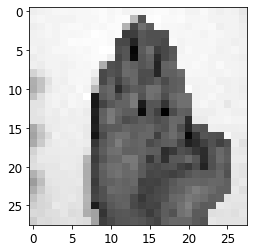

In [67]:
def preprocess(image_url):
  conn = urllib.request.urlopen(image_url) # connect
  # read image into 1D numpy array
  array = np.asarray(bytearray(conn.read()), dtype=np.uint8)
  # convert the 1D numpy array to image matrix
  img = cv.imdecode(array, -1)
  # convert to gray scale and resize image
  img = cv.resize(cv.cvtColor(img, cv.COLOR_RGB2GRAY), (28,28))
  return img.reshape(28,28,1)
test_image = preprocess('https://drive.google.com/uc?export=download&id=1iW8TmxwKOcQK4P85S2waAkC5SumpEIEv')
plot_image(test_image, width)

test image conversion makes image distorted to some extent. images that have size similar to test image should be used for training.

In [68]:
# split data into train and validation set with same target distribution as before spliting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [69]:
# create data augmentor and fit it on train set
generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, # make pixel intensity mean = 0 pixel-wise
    featurewise_std_normalization=True, # make pixel intensity s.d. = 1 pixel-wise
    height_shift_range=0.2, # shift image vertically (up or down) by 0.2 * 28 pixel
    width_shift_range=0.2, # shift image horizontally (left or right) by 0.2 * 28 pixel
    fill_mode='nearest'
)
generator.fit(X_train)

In [70]:
def plot_learning_curve(history):
    ephs = np.arange(0, len(history.history['loss'])) + 1
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(ephs, history.history['accuracy'], '--')
    plt.plot(ephs, history.history['val_accuracy'], '--')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(ephs, history.history['loss'], '--')
    plt.plot(ephs, history.history['val_loss'], '--')
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [71]:
def evaluate(model):
    loss_t, acc_t, pre_t, rec_t, auc_t = model.evaluate(generator.flow(X_train, y_train, batch_size=32))
    loss, acc, pre, rec, auc = model.evaluate(generator.flow(X_test, y_test, batch_size=32))
    print()
    print(f"train loss: {loss_t}")
    print(f"train accuracy: {round(acc_t*100,2)} %")
    print(f"train precision: {pre_t}")
    print(f"train recall: {rec_t}")
    print(f"train AUC: {auc_t}")
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test AUC: {auc}")
    print()
    index = int(input("Enter image index: ")) % X_test.shape[0]
    print(f"label: {np.argmax(model.predict(np.expand_dims([X_test[index]], axis=-1), verbose=0))}")
    print(f"actual label: {y_test[index].argmax()}")
    plot_image(X_test[index], width)

In [72]:
def build_base_model(func, init):
    keras.backend.clear_session()
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), padding="same", kernel_initializer=init(), input_shape=X_train.shape[1:]))
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (5, 5), padding="same", kernel_initializer=init()))
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(256, (5, 5), padding="same", kernel_initializer=init()))
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(y.shape[1], activation='softmax', kernel_initializer=init()))
    return model

In [73]:
'''
use elu activation as an alternative to avoid dead relu problem
he initialization is good for relu like activations
'''
model_base_uni = build_base_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
model_base_uni.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

model_base_norm = build_base_model(keras.activations.elu, keras.initializers.he_normal)
# compile model
model_base_norm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

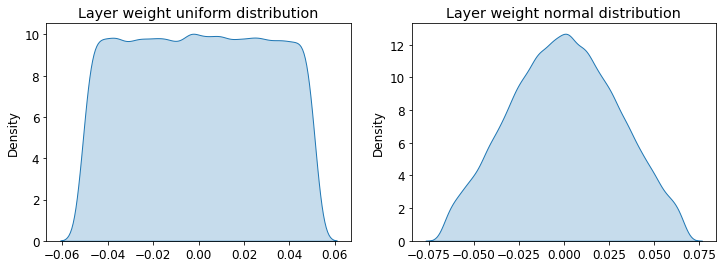

In [119]:
uni_dense_w = model_base_uni.layers[-1].get_weights()[0].ravel()
norm_dense_w = model_base_norm.layers[-1].get_weights()[0].ravel()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.kdeplot(x=uni_dense_w, fill=True)
plt.title('Layer weight uniform distribution')
plt.subplot(1,2,2)
sns.kdeplot(x=norm_dense_w, fill=True)
plt.title('Layer weight normal distribution')
plt.show()

In [132]:
r,c = model_base_uni.layers[-1].get_weights()[0].shape # get_weights give (weight, bias)
print('uniform weights should be between', -np.sqrt(6/c), 'and', np.sqrt(6/c)) # limit = sqrt(6 / fan_in)
print('uniform weights are between', min(uni_dense_w), 'and', max(uni_dense_w))
print()
# weights are randomly drawn from truncated normal distribution for model_base_norm with mean 0 and s.d. sqrt(2 / fan_in)

uniform weights should be between -0.4898979485566356 and 0.4898979485566356
uniform weights are between -0.051029954 and 0.051030055



In [141]:
cb_base = keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)

In [142]:
history_base_uni = model_base_uni.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val, y_val, batch_size=32), \
                    callbacks=[cb_base],
                    verbose=2)

Epoch 1/20
687/687 - 50s - loss: 5.1358 - accuracy: 0.1404 - precision: 0.2119 - recall: 0.0822 - auc: 0.6749 - val_loss: 3.9634 - val_accuracy: 0.2783 - val_precision: 0.3091 - val_recall: 0.2419 - val_auc: 0.7663
Epoch 2/20
687/687 - 16s - loss: 3.5626 - accuracy: 0.3214 - precision: 0.3595 - recall: 0.2846 - auc: 0.8155 - val_loss: 3.3448 - val_accuracy: 0.4114 - val_precision: 0.4360 - val_recall: 0.3903 - val_auc: 0.8519
Epoch 3/20
687/687 - 16s - loss: 3.1909 - accuracy: 0.4650 - precision: 0.4844 - recall: 0.4484 - auc: 0.8562 - val_loss: 2.3757 - val_accuracy: 0.5514 - val_precision: 0.5632 - val_recall: 0.5414 - val_auc: 0.8981
Epoch 4/20
687/687 - 16s - loss: 8.1595 - accuracy: 0.1468 - precision: 0.2192 - recall: 0.1171 - auc: 0.6343 - val_loss: 3.6769 - val_accuracy: 0.2519 - val_precision: 0.3828 - val_recall: 0.1668 - val_auc: 0.7749
Epoch 5/20
687/687 - 16s - loss: 3.0668 - accuracy: 0.4678 - precision: 0.4921 - recall: 0.4496 - auc: 0.8602 - val_loss: 2.6280 - val_accur

In [143]:
history_base_norm = model_base_norm.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val, y_val, batch_size=32), \
                    callbacks=[cb_base],
                    verbose=2)

Epoch 1/20
687/687 - 17s - loss: 3.6679 - accuracy: 0.4022 - precision: 0.4986 - recall: 0.3693 - auc: 0.8250 - val_loss: 2.0348 - val_accuracy: 0.6780 - val_precision: 0.6935 - val_recall: 0.6720 - val_auc: 0.9212
Epoch 2/20
687/687 - 16s - loss: 8.0882 - accuracy: 0.1656 - precision: 0.3084 - recall: 0.1417 - auc: 0.6134 - val_loss: 4.5749 - val_accuracy: 0.0435 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5153
Epoch 3/20
687/687 - 16s - loss: 5.6596 - accuracy: 0.0427 - precision: 0.0375 - recall: 0.0038 - auc: 0.5117 - val_loss: 5.5460 - val_accuracy: 0.0424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5068
Epoch 4/20
687/687 - 16s - loss: 3.6118 - accuracy: 0.0394 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5187 - val_loss: 3.5862 - val_accuracy: 0.0419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5258
Epoch 5/20
687/687 - 16s - loss: 3.6267 - accuracy: 0.0431 - precision: 0.0000e+00 - recall: 0.0000e+00 - au

learning curve of he uniform model


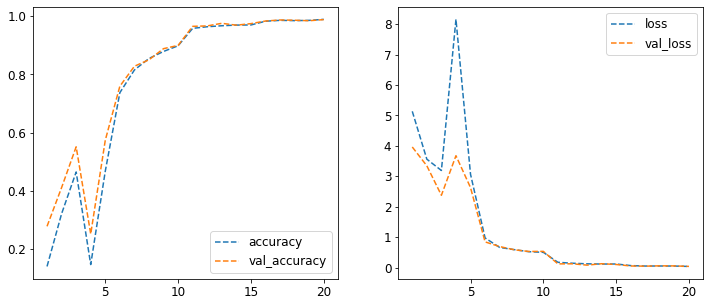

learning curve of he normal model


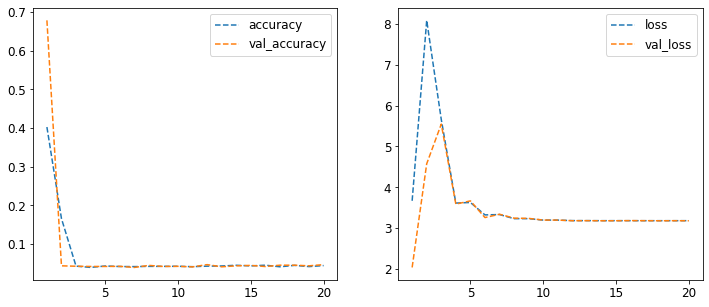

In [144]:
print("learning curve of he uniform model")
plot_learning_curve(history_base_uni)
print("learning curve of he normal model")
plot_learning_curve(history_base_norm)

225/225 [==============================] - 4s 20ms/step - loss: 0.1521 - accuracy: 0.9644 - precision: 0.9647 - recall: 0.9639 - auc: 0.9956

train loss: 0.03986889123916626
train accuracy: 98.9 %
train precision: 0.9891601204872131
train recall: 0.9887998700141907
train AUC: 0.9992303848266602
test loss: 0.15212661027908325
test accuracy: 96.44 %
test precision: 0.9646943807601929
test recall: 0.9638873338699341
test AUC: 0.9955559968948364

Enter image index: 22643
label: 2
actual label: 2


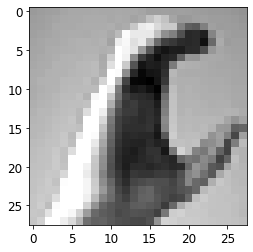

In [150]:
evaluate(model_base_uni)

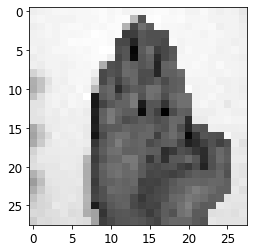

label: 1


In [172]:
plot_image(test_image, width)
print('label:', np.argmax(model_base_uni.predict(np.array([test_image]))))

In [160]:
# export model
model_base_uni.save('model_base.h5')

In [158]:
# inserted batch normalization layer before convolutional layers' activation
def build_model(func, init):
    keras.backend.clear_session()
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), padding="same", kernel_initializer=init(), input_shape=X_train.shape[1:]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (5, 5), padding="same", kernel_initializer=init()))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(256, (5, 5), padding="same", kernel_initializer=init()))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(func))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(y.shape[1], activation='softmax', kernel_initializer=init()))
    return model

In [159]:
model_elu = build_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
model_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [161]:
# deine callbacks, use AUC to minimize missclassification
cb_elu = [keras.callbacks.ModelCheckpoint('model_elu.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [170]:
history_elu = model_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=15, \
                    validation_data=generator.flow(X_val, y_val, batch_size=32), \
                    callbacks=cb_elu,
                    verbose=2)

Epoch 1/15
687/687 - 19s - loss: 1.3186 - accuracy: 0.6686 - precision: 0.8009 - recall: 0.6131 - auc: 0.9492 - val_loss: 0.3201 - val_accuracy: 0.9009 - val_precision: 0.9172 - val_recall: 0.8920 - val_auc: 0.9936
Epoch 2/15
687/687 - 17s - loss: 0.1659 - accuracy: 0.9486 - precision: 0.9569 - recall: 0.9409 - auc: 0.9978 - val_loss: 0.2664 - val_accuracy: 0.9173 - val_precision: 0.9255 - val_recall: 0.9119 - val_auc: 0.9951
Epoch 3/15
687/687 - 17s - loss: 0.1050 - accuracy: 0.9668 - precision: 0.9703 - recall: 0.9636 - auc: 0.9984 - val_loss: 0.1254 - val_accuracy: 0.9652 - val_precision: 0.9678 - val_recall: 0.9639 - val_auc: 0.9973
Epoch 4/15
687/687 - 17s - loss: 0.0963 - accuracy: 0.9717 - precision: 0.9738 - recall: 0.9698 - auc: 0.9981 - val_loss: 0.1438 - val_accuracy: 0.9601 - val_precision: 0.9623 - val_recall: 0.9588 - val_auc: 0.9962
Epoch 5/15
687/687 - 17s - loss: 0.0819 - accuracy: 0.9755 - precision: 0.9768 - recall: 0.9744 - auc: 0.9982 - val_loss: 0.0798 - val_accur

learning curve of he uniform model with batch normalization


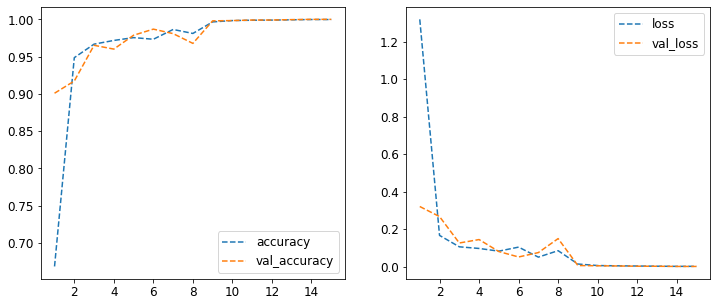

In [171]:
print(f"learning curve of he uniform model with batch normalization")
plot_learning_curve(history_elu)

225/225 [==============================] - 5s 20ms/step - loss: 0.0171 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9948 - auc: 0.9994

train loss: 0.0005923126009292901
train accuracy: 99.98 %
train precision: 0.9998179078102112
train recall: 0.9998179078102112
train AUC: 1.0
test loss: 0.017055220901966095
test accuracy: 99.5 %
test precision: 0.9951185584068298
test recall: 0.9948410391807556
test AUC: 0.9994190335273743

Enter image index: 12419621
label: 2
actual label: 2


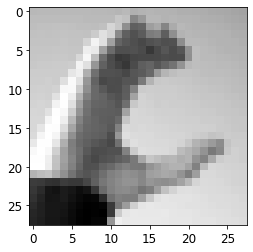

In [174]:
evaluate(model_elu)

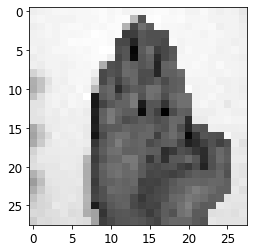

label:  16


In [175]:
plot_image(test_image, width)
print('label: ', np.argmax(model_elu.predict(np.array([test_image]))))

In [191]:
def build_dropout_model(func, init, drop_rate=0.4):
    keras.backend.clear_session()
    model = build_model(func, init)
    model.pop()
    # model.add(keras.layers.Dense(128, kernel_initializer=init()))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(y.shape[1], activation='softmax', kernel_initializer=init()))
    return model

In [192]:
# added extra drop out layer to prevent overfitting
drop_elu = build_dropout_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
drop_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [193]:
# deine model callback
cb_elu_dropout = [keras.callbacks.ModelCheckpoint('model_dropout_elu.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [194]:
history_dropout_elu = drop_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu_dropout,
                    verbose=2)

Epoch 1/20
687/687 - 19s - loss: 1.4450 - accuracy: 0.6371 - precision: 0.7499 - recall: 0.5828 - auc: 0.9401 - val_loss: 0.3665 - val_accuracy: 0.8869 - val_precision: 0.9073 - val_recall: 0.8649 - val_auc: 0.9931
Epoch 2/20
687/687 - 17s - loss: 0.2656 - accuracy: 0.9145 - precision: 0.9293 - recall: 0.9031 - auc: 0.9955 - val_loss: 0.0872 - val_accuracy: 0.9720 - val_precision: 0.9769 - val_recall: 0.9692 - val_auc: 0.9995
Epoch 3/20
687/687 - 16s - loss: 0.1615 - accuracy: 0.9487 - precision: 0.9546 - recall: 0.9445 - auc: 0.9973 - val_loss: 0.1294 - val_accuracy: 0.9588 - val_precision: 0.9640 - val_recall: 0.9570 - val_auc: 0.9976
Epoch 4/20
687/687 - 16s - loss: 0.1500 - accuracy: 0.9568 - precision: 0.9609 - recall: 0.9541 - auc: 0.9969 - val_loss: 0.1395 - val_accuracy: 0.9588 - val_precision: 0.9620 - val_recall: 0.9577 - val_auc: 0.9979
Epoch 5/20
687/687 - 17s - loss: 0.0384 - accuracy: 0.9883 - precision: 0.9895 - recall: 0.9875 - auc: 0.9994 - val_loss: 0.0138 - val_accur

learning curve of he uniform model with dropout and batch norm


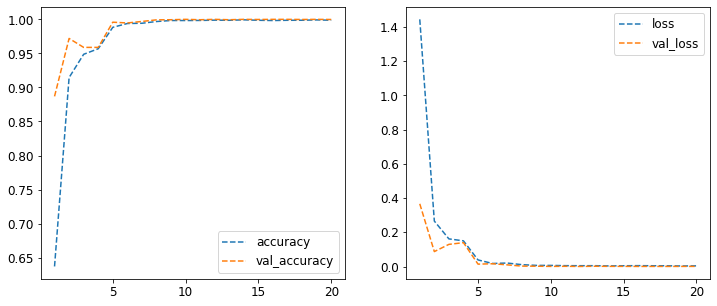

In [206]:
print(f"learning curve of he uniform model with dropout and batch norm")
plot_learning_curve(history_dropout_elu)

225/225 [==============================] - 4s 20ms/step - loss: 0.0121 - accuracy: 0.9954 - precision: 0.9957 - recall: 0.9948 - auc: 1.0000

train loss: 0.0004152224282734096
train accuracy: 100.0 %
train precision: 0.9999544620513916
train recall: 0.9999544620513916
train AUC: 1.0
test loss: 0.012104406952857971
test accuracy: 99.54 %
test precision: 0.9956740140914917
test recall: 0.9948410391807556
test AUC: 0.9999967217445374

Enter image index: 687140
label: 21
actual label: 21


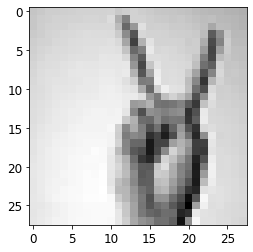

In [196]:
evaluate(drop_elu)

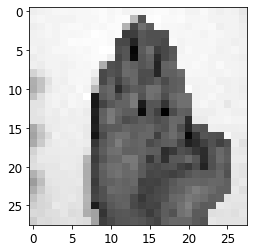

label:  16


In [197]:
plot_image(test_image, width)
print('label: ', np.argmax(drop_elu.predict(np.array([test_image]))))

In [199]:
from sklearn.utils import class_weight
w = class_weight.compute_class_weight('balanced', np.unique(y_train.argmax(axis=1)), y_train.argmax(axis=1))

In [200]:
# to train with class weights
elu_3 = build_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
elu_3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [201]:
cb_elu_3 = [keras.callbacks.ModelCheckpoint('model_elu3_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [202]:
history_elu3 = elu_3.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=20, \
                    validation_data=generator.flow(X_val, y_val, batch_size=32), \
                    callbacks=cb_elu_3,
                    verbose=2,
                    class_weight=dict(enumerate([*w[0:9],0,*w[9:]])))

Epoch 1/20
687/687 - 18s - loss: 1.3590 - accuracy: 0.6592 - precision: 0.7969 - recall: 0.5993 - auc: 0.9469 - val_loss: 0.2820 - val_accuracy: 0.9131 - val_precision: 0.9290 - val_recall: 0.9026 - val_auc: 0.9947
Epoch 2/20
687/687 - 16s - loss: 0.1737 - accuracy: 0.9445 - precision: 0.9534 - recall: 0.9372 - auc: 0.9978 - val_loss: 0.1295 - val_accuracy: 0.9587 - val_precision: 0.9643 - val_recall: 0.9537 - val_auc: 0.9979
Epoch 3/20
687/687 - 16s - loss: 0.1061 - accuracy: 0.9676 - precision: 0.9712 - recall: 0.9643 - auc: 0.9982 - val_loss: 0.0916 - val_accuracy: 0.9725 - val_precision: 0.9746 - val_recall: 0.9701 - val_auc: 0.9985
Epoch 4/20
687/687 - 16s - loss: 0.0863 - accuracy: 0.9733 - precision: 0.9755 - recall: 0.9716 - auc: 0.9984 - val_loss: 0.1256 - val_accuracy: 0.9687 - val_precision: 0.9706 - val_recall: 0.9669 - val_auc: 0.9974
Epoch 5/20
687/687 - 16s - loss: 0.0798 - accuracy: 0.9761 - precision: 0.9779 - recall: 0.9749 - auc: 0.9984 - val_loss: 0.1219 - val_accur

learning curve of he uniform model with batch norm class weight


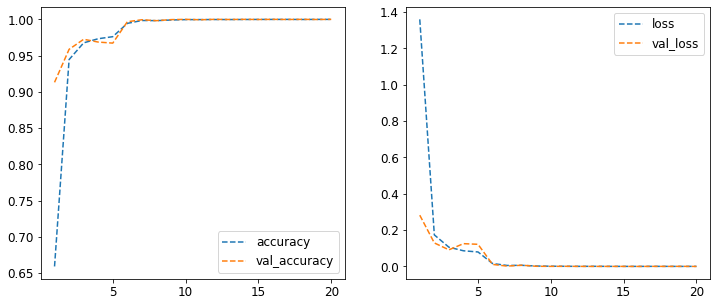

In [207]:
print(f"learning curve of he uniform model with batch norm class weight")
plot_learning_curve(history_elu3)

225/225 [==============================] - 5s 20ms/step - loss: 0.0110 - accuracy: 0.9962 - precision: 0.9962 - recall: 0.9961 - auc: 0.9999

train loss: 0.0002476437948644161
train accuracy: 100.0 %
train precision: 1.0
train recall: 1.0
train AUC: 0.9999999403953552
test loss: 0.010958658531308174
test accuracy: 99.62 %
test precision: 0.9962348341941833
test recall: 0.9960959553718567
test AUC: 0.9999275207519531

Enter image index: 7162498
label: 6
actual label: 6


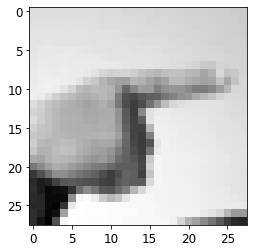

In [204]:
evaluate(elu_3)

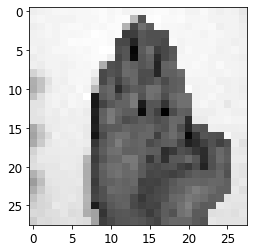

label:  1


In [208]:
plot_image(test_image, width)
print('label: ', np.argmax(elu_3.predict(np.array([test_image]))))